In [2]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import glob
from natsort import natsorted
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
import seaborn as sns

In [3]:
# メタデータの読み込み
train_master = pd.read_csv('train_master.csv', index_col=0) 
label_master = pd.read_csv('label_master.csv')
sample_submit = pd.read_csv('sample_submit.csv', header=None)

label_list = label_master.to_dict()['label_name']
print("ラベル:", label_list)
print("訓練データ数:", len(train_master))

ラベル: {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
訓練データ数: 500


In [4]:
# 訓練データのMFCC特徴量を抽出
def extract_mfcc(file_path, n_mfcc=13, max_len=1225):
    """MFCCを抽出し、固定長にする"""
    try:
        y, sr = librosa.load(file_path)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

        # 固定長にパディング/トリミング
        if mfccs.shape[1] < max_len:
            pad_width = max_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant') 
        else:
            mfccs = mfccs[:, :max_len]

        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# 訓練データのMFCC特徴量を抽出
train_files = natsorted(glob.glob('train_sound/train_*.au'))
print(f"訓練ファイル数: {len(train_files)}")

X_train = []
y_train = []

for i, file_path in enumerate(train_files):
    if i % 50 == 0:
        print(f"処理中: {i}/{len(train_files)}")

    mfccs = extract_mfcc(file_path)
    if mfccs is not None:
        X_train.append(mfccs)
        # ファイル名からインデックスを取得してラベルを設定
        file_index = int(file_path.split('_')[-1].split('.')[0])
        y_train.append(train_master.iloc[file_index]['label_id'])

X_train = np.array(X_train)
y_train = np.array(y_train)

print(f"訓練データ形状: {X_train.shape}")
print(f"ラベル形状: {y_train.shape}")

訓練ファイル数: 55
処理中: 0/55
処理中: 50/55
訓練データ形状: (55, 13, 1225)
ラベル形状: (55,)


In [5]:
X_train[0]

array([[-2.9154437e+02, -3.2697028e+02, -3.7157651e+02, ...,
        -2.6099957e+02, -1.6652518e+02, -9.6678123e+01],
       [ 1.3327460e+02,  1.4387894e+02,  1.4997879e+02, ...,
         7.1150665e+01,  1.9313765e+01,  4.4951397e+01],
       [ 1.2925331e+01,  1.3425854e+01,  5.0640240e+00, ...,
         2.6052231e+01,  6.9808240e+00, -5.3907304e+00],
       ...,
       [-3.4750593e+00, -3.1994039e-01, -3.3792198e-01, ...,
        -1.7999187e+01, -3.0828600e+01, -3.7338398e+01],
       [ 1.7632127e+00, -1.2095094e+00,  1.0465441e+00, ...,
         1.4436602e+01,  8.1730366e+00,  4.2098145e+00],
       [-5.6228380e+00, -7.7131543e+00, -9.6250081e-01, ...,
        -1.9077412e+01, -2.3807768e+01, -2.1989159e+01]], dtype=float32)

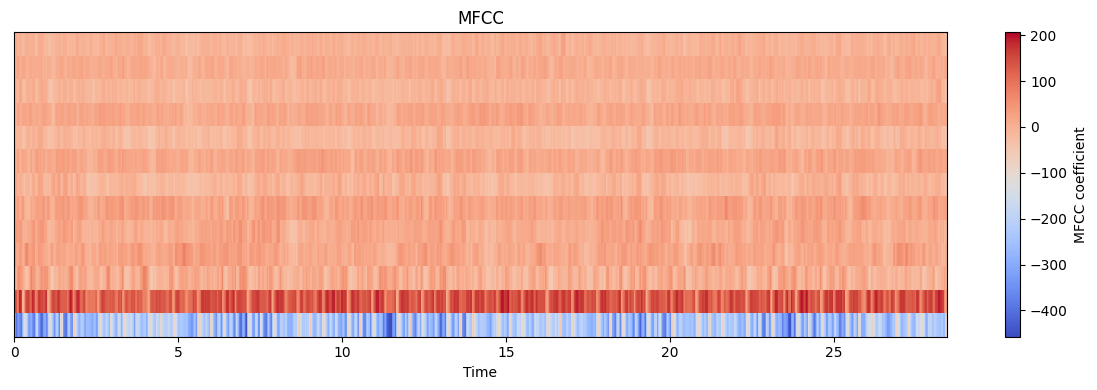

最大フレーム数: 1225, 特徴量次元数: 13
27011250


In [6]:
train_files = natsorted(glob.glob('train_sound/train_*.au'))
sample_file = train_files[0]
y, sr = librosa.load(sample_file)

plt.figure(figsize=(12, 4))
librosa.display.specshow(X_train[0], x_axis='time', sr=sr)
plt.colorbar(label='MFCC coefficient')
plt.title('MFCC')
plt.tight_layout()
plt.show()

max_len = 1225
str_ = f"最大フレーム数: {max_len}, 特徴量次元数: {X_train.shape[1]}"
print(str_)
print(sr * max_len)

In [7]:
# テストデータのMFCC特徴量を抽出
test_files = natsorted(glob.glob('test_sound/test_*.au'))
print(f"テストファイル数: {len(test_files)}")

X_test = []

for i, file_path in enumerate(test_files):
    if i % 50 == 0:
        print(f"処理中: {i}/{len(test_files)}")

    mfccs = extract_mfcc(file_path)
    if mfccs is not None:
        X_test.append(mfccs)

X_test = np.array(X_test)
print(f"テストデータ形状: {X_test.shape}")

テストファイル数: 500
処理中: 0/500
処理中: 50/500
処理中: 100/500
処理中: 150/500
処理中: 200/500
処理中: 250/500
処理中: 300/500
処理中: 350/500
処理中: 400/500
処理中: 450/500
テストデータ形状: (500, 13, 1225)


In [8]:
# データの前処理
# CNNのために次元を追加（チャンネル次元）
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],
X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],
X_test.shape[2], 1)

# ラベルをone-hot encodingに変換
y_train_categorical = to_categorical(y_train, num_classes=10)

# 訓練データを訓練用と検証用に分割
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train_categorical, test_size=0.2, random_state=42,stratify=y_train)

print(f"訓練データ形状: {X_train_split.shape}")
print(f"検証データ形状: {X_val_split.shape}")
print(f"テストデータ形状: {X_test.shape}")

訓練データ形状: (44, 13, 1225, 1)
検証データ形状: (11, 13, 1225, 1)
テストデータ形状: (500, 13, 1225, 1)


In [9]:
# CNNモデルの構築（修正版）
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(13, 1225, 1), padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# モデルのコンパイル
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# モデルの構造を表示
model.summary()

/mnt/d/kishi/Github/signate_music_labeling/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1759211097.234259   42589 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21742 MB memory:  -> device: 0, name: NVIDIA RTX 4500 Ada Generation, pci bus id: 0000:16:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 13, 1225, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 1225, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 6, 612, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 612, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,090 (461.29 KB)

 Trainable params: 118,090 (461.29 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# モデルの訓練
history = model.fit(
    X_train_split, y_train_split,
    batch_size=32,
    epochs=50,
    validation_data=(X_val_split, y_val_split),
    verbose=1
)

Epoch 1/50


I0000 00:00:1759211103.344224   45653 service.cc:148] XLA service 0x7b6944024cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759211103.344573   45653 service.cc:156]   StreamExecutor device (0): NVIDIA RTX 4500 Ada Generation, Compute Capability 8.9
2025-09-30 14:45:03.414984: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759211103.668340   45653 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-09-30 14:45:04.577452: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1324', 60 bytes spill stores, 64 bytes spill loads



1/2 ━━━━━━━━━━━━━━━━━━━━ 6s 7s/step - accuracy: 0.0625 - loss: 4.2980

I0000 00:00:1759211108.238942   45653 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step - accuracy: 0.0511 - loss: 4.4014 - val_accuracy: 0.0909 - val_loss: 2.5017
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.0814 - loss: 3.4874 - val_accuracy: 0.0909 - val_loss: 2.1884
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1629 - loss: 3.0021 - val_accuracy: 0.1818 - val_loss: 2.2727
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.0919 - loss: 2.6251 - val_accuracy: 0.1818 - val_loss: 2.2657
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.0919 - loss: 3.0176 - val_accuracy: 0.1818 - val_loss: 2.1856
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.0663 - loss: 2.5232 - val_accuracy: 0.0909 - val_loss: 2.1953
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1023 - loss: 2.4260 - val_accuracy: 0.1818 - val_loss: 2.1808
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.1430 - loss: 2.3203 - val_accuracy: 0.0909 - val_loss: 2.1704
Epoch 9/50
2

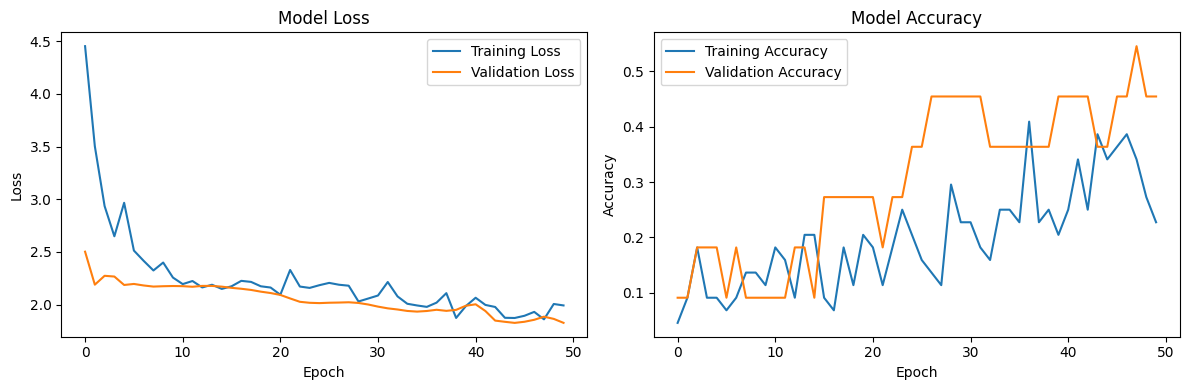

検証精度: 0.4545


In [11]:
# 訓練履歴の可視化
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 最終的な検証精度
val_loss, val_accuracy = model.evaluate(X_val_split, y_val_split,
verbose=0)
print(f"検証精度: {val_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
分類レポート:
              precision    recall  f1-score   support

       blues       0.00      0.00      0.00         1
   classical       0.50      1.00      0.67         2
     country       0.00      0.00      0.00         1
       disco       0.33      1.00      0.50         1
      hiphop       0.00      0.00      0.00         1
        jazz       0.00      0.00      0.00         1
       metal       1.00      1.00      1.00         1
         pop       0.00      0.00      0.00         1
      reggae       0.33      1.00      0.50         1
        rock       0.00      0.00      0.00         1

    accuracy                           0.45        11
   macro avg       0.22      0.40      0.27        11
weighted avg       0.24      0.45      0.30        11



/mnt/d/kishi/Github/signate_music_labeling/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/d/kishi/Github/signate_music_labeling/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/d/kishi/Github/signate_music_labeling/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

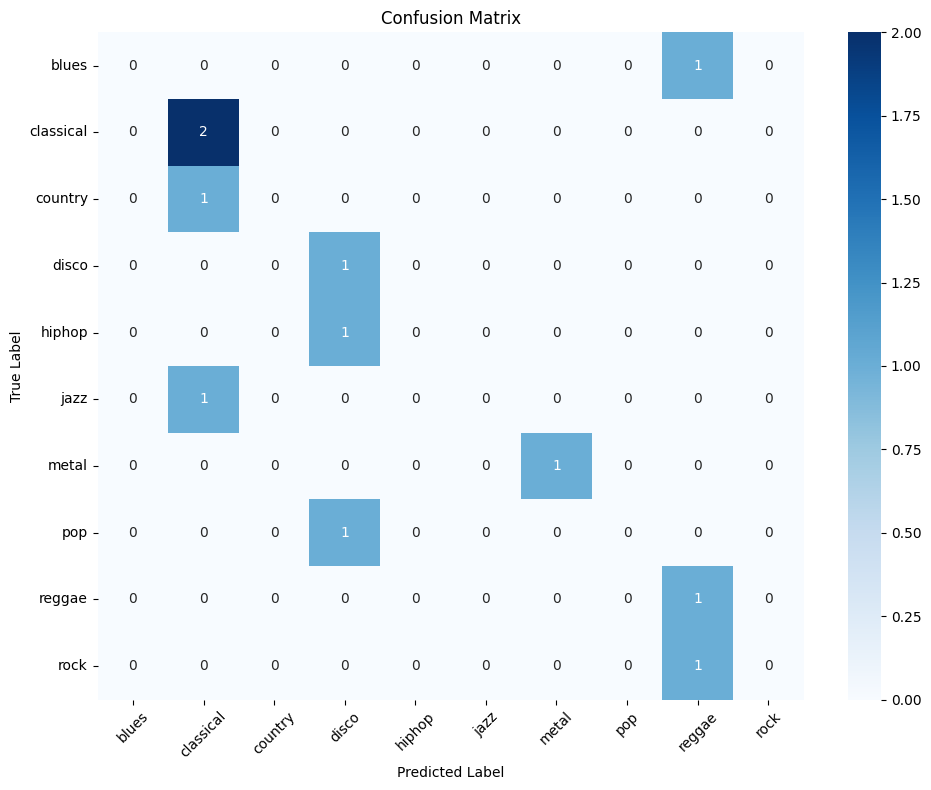

In [12]:
# 詳細な評価
y_pred = model.predict(X_val_split)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val_split, axis=1)

# 分類レポート
print("分類レポート:")
print(classification_report(y_true_classes, y_pred_classes,
                            target_names=[label_list[i] for i in
range(10)]))

# 混同行列
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[label_list[i] for i in range(10)],
            yticklabels=[label_list[i] for i in range(10)])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step


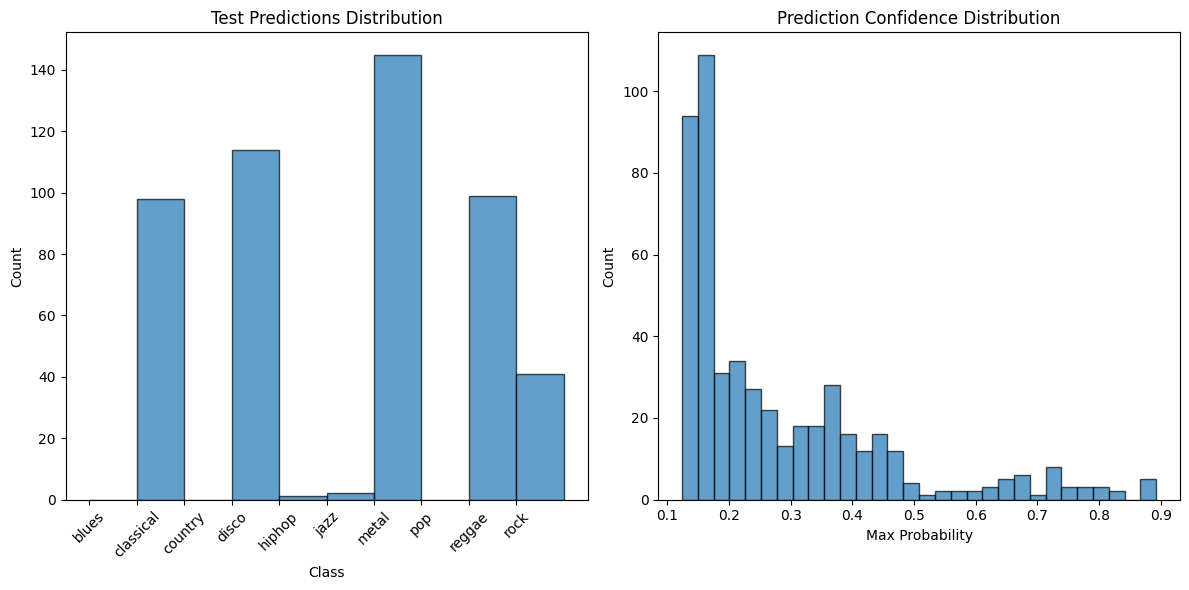

テストデータの予測完了: 500件
平均予測信頼度: 0.2808


In [13]:
# テストデータの予測
test_predictions = model.predict(X_test)
test_pred_classes = np.argmax(test_predictions, axis=1)

# 予測結果の確率分布を表示
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(test_pred_classes, bins=range(11), alpha=0.7,
edgecolor='black')
plt.title('Test Predictions Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(range(10), [label_list[i] for i in range(10)],
rotation=45)

# 予測の信頼度分布
plt.subplot(1, 2, 2)
max_probs = np.max(test_predictions, axis=1)
plt.hist(max_probs, bins=30, alpha=0.7, edgecolor='black')
plt.title('Prediction Confidence Distribution')
plt.xlabel('Max Probability')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

print(f"テストデータの予測完了: {len(test_pred_classes)}件")
print(f"平均予測信頼度: {np.mean(max_probs):.4f}")

In [14]:
# 結果をCSVファイルに保存
submission = pd.DataFrame({
    'id': sample_submit[0],
    'label_id': test_pred_classes
})

submission.to_csv('submission_cnn_mfcc.csv', index=False,
header=False)
print("予測結果をsubmission_cnn_mfcc.csvに保存しました")

# サンプル結果表示
print("\n予測結果の最初の10件:")
for i in range(10):
    print(f"Test {i}: {label_list[test_pred_classes[i]]} (信頼度: {max_probs[i]:.3f})")

予測結果をsubmission_cnn_mfcc.csvに保存しました

予測結果の最初の10件:
Test 0: disco (信頼度: 0.156)
Test 1: rock (信頼度: 0.152)
Test 2: reggae (信頼度: 0.233)
Test 3: metal (信頼度: 0.489)
Test 4: classical (信頼度: 0.869)
Test 5: reggae (信頼度: 0.226)
Test 6: reggae (信頼度: 0.365)
Test 7: reggae (信頼度: 0.196)
Test 8: classical (信頼度: 0.195)
Test 9: classical (信頼度: 0.638)


In [15]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))
print("CUDA build:", tf.test.is_built_with_cuda())

# GPU使用状況の詳細確認
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Number of GPUs: {len(gpus)}")
    for i, gpu in enumerate(gpus):
        print(f"GPU {i}: {gpu}")
        
    # メモリ成長を有効にする（必要に応じて）
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(f"Memory growth setting failed: {e}")
else:
    print("No GPUs detected")
    
# 利用可能なデバイス一覧
print("\nAvailable devices:")
for device in tf.config.list_logical_devices():
    print(f"  {device}")

TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CUDA build: True
Number of GPUs: 1
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Memory growth setting failed: Physical devices cannot be modified after being initialized

Available devices:
  LogicalDevice(name='/device:CPU:0', device_type='CPU')
  LogicalDevice(name='/device:GPU:0', device_type='GPU')
